In [1]:
import numpy as np
import import_ipynb
from lib.draw import board_to_svg
from IPython.display import SVG

importing Jupyter notebook from /home/nikita/Code/Thesis/source/lib/draw.ipynb


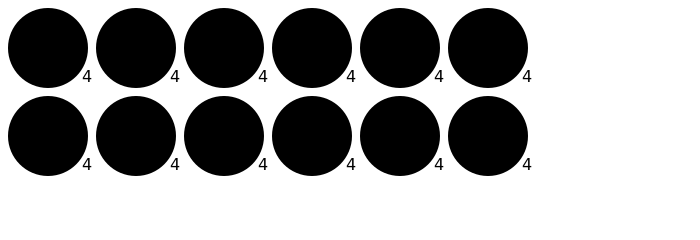

In [2]:
board = np.full((2, 6), 4)
SVG(board_to_svg(board, True))

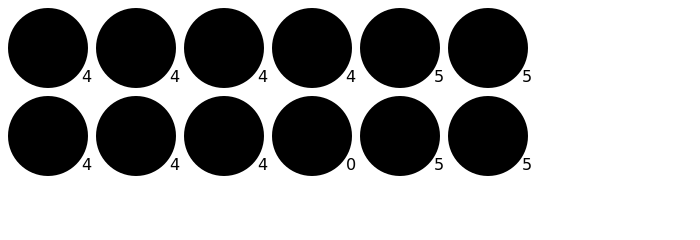

In [3]:
board = np.array([
    [4, 4, 4, 4, 5, 5],
    [4, 4, 4, 0, 5, 5],
])
SVG(board_to_svg(board, True,highlight=[(1, 3)]))

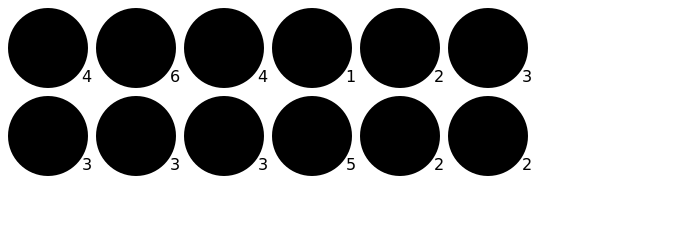

In [4]:
board = np.array([
    [4, 6, 4, 1, 2, 3],
    [3, 3, 3, 5, 2, 2],
])
SVG(board_to_svg(board, True,highlight=[(1, 3)]))

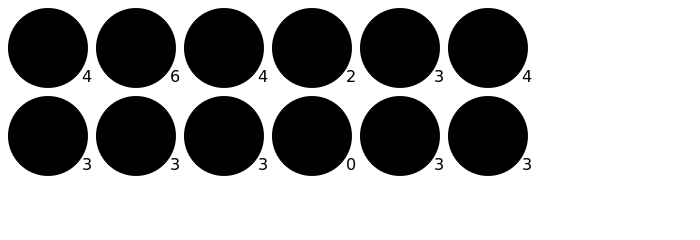

In [5]:
board = np.array([
    [4, 6, 4, 2, 3, 4],
    [3, 3, 3, 0, 3, 3],
])
SVG(board_to_svg(board, True,highlight=[(0, 3), (0, 4)]))

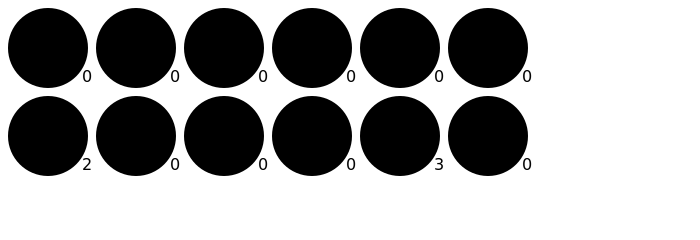

In [6]:
board = np.array([
    [0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 3, 0],
])
SVG(board_to_svg(board, True,highlight=[(1, 4)]))

In [7]:
import numpy as np
import itertools
from typing import List, Dict, Set, Optional, Tuple

In [8]:
from dataclasses import dataclass

@dataclass
class Game:
    pits: np.array # a 2x6 matrix containing the number of seeds in each pits
    current_player: int # 0 for South and 1 for North
    captures: np.array # the number of seeds captured by each player

In [9]:
class Game(Game):
    ...
    
    @classmethod
    def new(klass):
        return klass(
            # A 6x2 matrix filled with 4 seeds
            pits=np.ones(6 * 2, dtype=int) * 4,
            # North is the first player
            current_player=0,
            # No captures have been made
            captures=np.zeros(2, dtype=int),
        )

In [10]:
class Game(Game):
    ...

    @property
    def view_from_current_player(self) -> List[int]:
        '''Returns the board as seen by a player'''
        if self.current_player == 0:
            return self.pits
        else:
            return np.roll(self.pits, 6)
    
    @property
    def current_player_pits(self) -> List[int]:
        '''Returns a 6-vector containing the pits owned by the current player'''
        if self.current_player == 0:
            return self.pits[:6]
        else:
            return self.pits[6:]

    @property
    def current_opponent(self) -> int:
        return (self.current_player + 1) % 2
    
    @property
    def adverse_pits_idx(self) -> List[int]:
        '''Returns the indices in the `self.pits` array owned by the opposing player'''
        if self.current_player == 1:
            return list(range(6))
        else:
            return list(range(6, 6 * 2))

In [11]:
class Game(Game):
    ...
    
    @property
    def legal_actions(self) -> List[int]:
        '''Returns a list of indices for each legal action for the current player'''
        our_pits = self.current_player_pits
        # Return every pit of the player that contains some seeds
        return [x for x in range(6) if our_pits[x] != 0]
    
    @property
    def game_finished(self) -> bool:
        # Does the current player has an available move ?
        no_moves_left = np.sum(self.current_player_pits) == 0
        
        # Has one player cpatured more than half the total seeds ?
        HALF_SEEDS = 24 # (there are 2*6*4=48 seeds in total)
        enough_captures = self.captures[0] > HALF_SEEDS or self.captures[1] > HALF_SEEDS
        
        # Is it a draw ? Does both player have 24 seeds ?
        draw = self.captures[0] == HALF_SEEDS and self.captures[1] == HALF_SEEDS
        
        # If one of the above three are True, the game is finished
        return no_moves_left or enough_captures or draw
    
    @property
    def winner(self) -> Optional[int]:
        '''Returns the winner of the game or None if the game is not finished or in a draw'''
        if not self.game_finished:
            return None
        # The game is finished but both player have the same amount of seeds: it's a draw
        elif self.captures[0] == self.captures[1]:
            return None
        # Else, there is a winner: the player with the most seeds
        else:
            return 0 if self.captures[0] > self.captures[1] else 1

In [12]:
class Game(Game):
    ...
    
    def step(self, action: int) -> Tuple[Game, int, bool]:
        '''Plays the action given as parameter and returns:
            - a the new state as a new Game object,
            - the amount of captured stones in the transition
            - a bool indicating if the new state is the end of the game
        '''
        assert 0 <= action < 6, "Illegal action"
        
        # Translate the action index to a pit index
        target_pit = action if self.current_player == 0 else action - 6
        
        seeds = self.pits[target_pit]
        assert seeds != 0, "Illegal action: pit % is empty" % target_pit
        
        # Copy the attributes of `Game` so that the original
        # stays immutable
        pits = np.copy(self.pits)
        captures = np.copy(self.captures)
        
        # Empty the pit targeted by the player 
        pits[target_pit] = 0
        
        # Fill the next pits while there are still seeds
        pit_to_sow = target_pit
        while seeds > 0:
            pit_to_sow = (pit_to_sow + 1) % (6 * 2)
            # Do not fill the target pit ever
            if pit_to_sow != target_pit:
                pits[pit_to_sow] += 1
                seeds -= 1

        # Count the captures of the play
        round_captures = 0
        
        # If the last seed was in a adverse pit we can try to collect seeds
        if pit_to_sow in self.adverse_pits_idx:
            # If the pit contains 2 or 3 seeds, we capture them
            while pits[pit_to_sow] in (2, 3):
                captures[self.current_player] += pits[pit_to_sow]
                round_captures += pits[pit_to_sow]
                pits[pit_to_sow] = 0
                
                # Select backwards the next pit to check
                pit_to_sow = (pit_to_sow - 1) % (self.n_pits * 2)
        
        # Change the current player
        current_player = (self.current_player + 1) % 2
        
        # Create the new `Game` instance
        new_game = type(self)(
            pits,
            current_player,
            captures
        )

        return new_game, round_captures, new_game.game_finished


In [13]:
class Game(Game):
    ...
    
    def show_state(self):
        '''Print a textual representation of the game to the stdandard output'''
        if self.game_finished:
            print("Game finished")
        print("Current player: {} - Score: {}/{}\n{}".format(
            self.current_player,
            self.captures[self.current_player],
            self.captures[(self.current_player + 1) % 2],
            "-" * 6 * 3
        ))
        
        pits = []
        for seeds in self.view_from_current_player:
            pits.append("{:3}".format(seeds))
        
        print("".join(reversed(pits[6:])))
        print("".join(pits[:6]))
    
    def _repr_svg_(self):
        '''Return a SVG file representing the current state to be displayed in a notebook'''
        board = np.array([
            list(reversed(self.pits[6:])),
            self.pits[:6]
        ])
        return board_to_svg(board, True)

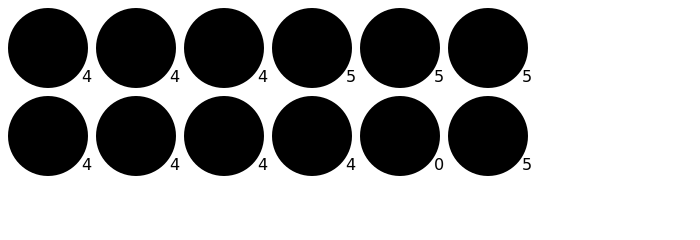

In [14]:
g = Game.new() # Create a new game
g, captures, done = g.step(4) # play the 5th pit (our implementation starts at 0)
g # Display the resulting board inline

In [15]:
from typing import Optional, List
from dataclasses import field
import weakref import ref

@dataclass
class TreeGame(Game):
    # Hold an optional reference to the parent state
    parent: Optional[ref[Game]] = None
    # Hold a list of 6 optional references to the children
    children: List[Optional[Game]] = field(default_factory=lambda: [None] * 6)
    depth: int

In [16]:
class TreeGame(TreeGame):
    ...
    
    def step(self, action):
        # If we already did compute the children node, just return it
        if self.children[action] is not None:
            new_game = self.children[action]
            captures = new_game.captures[self.current_player] - self.captures[self.current_player]
            return new_game, captures, new_game.game_finished
        # If not, call the original `step()` method and keep references in both directions
        else:
            new_game, captures, finished = super().step(action)
            new_game.parent = ref(self)
            new_game.depth = self.depth + 1
            self.children[action] = new_game
            return new_game, captures, finished

In [17]:
class TreeGame(TreeGame):
    ...

    @property
    def successors(self):
        children = [x for x in self.children if x is not None]
        successors = children + list(itertools.chain(*[x.successors for x in children]))
        return successors
    
    @property
    def unvisited_actions(self):
        return [i for i, x in enumerate(self.children) if x is None]

    @property
    def legal_unvisited_actions(self):
        return list(set(self.unvisited_actions).intersection(set(self.legal_actions)))
    
    @property
    def expanded_children(self):
        return [x for x in self.children if x is not None]
    
    @property
    def is_fully_expanded(self):
        legal_actions = set(self.legal_actions)
        unvisited_actions = set(self.unvisited_actions)
        return len(legal_actions.intersection(unvisited_actions)) == 0
    
    @property
    def is_leaf_game(self):
        return self.children == [None] * 6

In [18]:
@dataclass
class TreeStatsGame(TreeGame):
    wins: np.array = field(default_factory=np.zeros(2, dtype=int))
    n_playouts: int = 0
    
    
    def update_stats(self, winner):
        assert winner in [0, 1]
        self.wins[winner] += 1
        self.n_playouts += 1
        if self.parent():
            self.parent().update_stats(winner)